In [151]:
from dolfin import *
import numpy as np
import sys as sys
sys.path.append('../src/3D_to_1D/')
sys.path.append('../src/3D_to_1D/scripts/')
import pvs1D_utils as utils
import imp as imp
imp.reload(utils)

import pvs1D_utils as utils
from post_process import *

## Read meshes

In [152]:
# Read 1d mesh
mesh1D = Mesh()
case_path = '../src/C0092/'
results_path = '../results/results_B2/'
case_prefix = 'C0092_clip1_mesh1_0.95_ratio'
mesh1D_file = case_path + case_prefix + "_centerline_mesh.xdmf"
with XDMFFile(MPI.comm_world, mesh1D_file) as xdmf:
    xdmf.read(mesh1D)

# Read 1d coarse mesh
# (generated by make_coarse_1D_mesh.py)
mesh1D_c = Mesh()

mesh1D_file = results_path + "avg/XDMF/mesh1D_c_0.xdmf"
with XDMFFile(MPI.comm_world, mesh1D_file) as xdmf:
    xdmf.read(mesh1D_c)
    
# Shrink the geometry with a given constant
L_PVS = 44e-3 # [mm]
coord_factor = 2.0/L_PVS
    
mesh1D.coordinates()[:]/=coord_factor
# mesh1D_c does not have to be shrunk, as it was generated from mesh1D

# Read in radius
radius_hfile  = HDF5File(MPI.comm_world, case_path + case_prefix + "_HDF5/centerline_radius.h5", "r")
radius_a = Function(FunctionSpace(mesh1D, 'CG', 1))
radius_hfile.read(radius_a, "/function/vector_0")

radius_a.vector()[:]/=coord_factor #shrink

radius_a.vector()[:]*=0.5 # why is this needed?

radius_pv = project(2.95*radius_a, FunctionSpace(mesh1D, 'CG', 1))

mesh3D = Mesh()
mesh3D_file = case_path + case_prefix + "_PVS.xdmf"
with XDMFFile(MPI.comm_world, mesh3D_file) as xdmf:
    xdmf.read(mesh3D)
    
mesh3D.coordinates()[:]/=coord_factor

A_pv = project(3.14159*(radius_pv**2.0-radius_a**2.0), FunctionSpace(mesh1D, 'CG', 1))

In [196]:
V = VectorElement("CG", mesh3D.ufl_cell(), 2)
Q = FiniteElement("CG", mesh3D.ufl_cell(), 1)
VQ = FunctionSpace(mesh3D, MixedElement(V, Q))
1067/VQ.dim()*100


0.3712182359653762

## Read parameters

In [177]:
import json
import pandas as pd
param_f = open (results_path + 'params.json', "r")
params = json.load(param_f)
param_f.close()

params["dt"]

0.005

## Read solutions

In [154]:
## Read in 1d solutions, 3d solutions and 3d averages ##

file_u = HDF5File(MPI.comm_world, results_path + '3D/HDF5/u.h5','r')
file_p = HDF5File(MPI.comm_world, results_path + '3D/HDF5/p.h5','r')

file_u_avg = HDF5File(MPI.comm_world, results_path + 'avg/HDF5/q_avg0.h5','r')
file_p_avg = HDF5File(MPI.comm_world, results_path + 'avg/HDF5/p_avg.h5','r')

file_p1D = HDF5File(MPI.comm_world, results_path + '1D/HDF5/p1D.h5','r')
file_q1D = HDF5File(MPI.comm_world, results_path + '1D/HDF5/q1D0.h5','r')

V1_c = FunctionSpace(mesh1D_c, 'CG', 1)

attr = file_u.attributes("/function")
nsteps = attr['count'] 

tang_comps = read_tangent(case_path, mesh1D, [])
correction_factor = compute_correction_factor(tang_comps, R1, R2, mesh1D_c, mesh3D)

V1_c = FunctionSpace(mesh1D_c, 'CG', 1)

us, ps, u_avgs, p_avgs, q1Ds, p1Ds = [], [], [], [], [], []
for i in range(1, nsteps-2):
    name = "/function/vector_%d"%i

    u = Function(VectorFunctionSpace(mesh3D, "CG", 2))
    file_u.read(u, name)
    us.append(u)

    p = Function(FunctionSpace(mesh3D, "CG", 1))
    file_p.read(p, name)
    ps.append(p)
    
    p_avg = Function(FunctionSpace(mesh1D, "CG", 1))
    file_p_avg.read(p_avg, name)
    p_avgs.append(p_avg)
    
    u_avg = Function(FunctionSpace(mesh1D_c, "CG", 1))
    file_u_avg.read(u_avg, name)
    u_avgs.append(u_avg)

    # Read in 1D solutions at this time step
    q1D = Function(FunctionSpace(mesh1D, "CG", 2))
    file_q1D.read(q1D, name)
    
    p1D = Function(FunctionSpace(mesh1D, "CG", 1))
    file_p1D.read(p1D, name)
    
    # Add to solution lists
    q1Ds.append(q1D)
    p1Ds.append(p1D)
    
file_p_avg.close()
file_u_avg.close()

## Plot time dependent quantities

In [155]:
# We make a list of the solution at some fixed point x for different times

# For the points we use the cross-section centerpoints used in the paper
x_top = V1_c.tabulate_dof_coordinates()[60] # point at top cross section
x_bot = V1_c.tabulate_dof_coordinates()[len(mesh1D_c.coordinates())-60] # point at bottom cross section

q_avg_top = [q_avg(x_top) for q_avg in u_avgs]
p_avg_top = [p_avg(x_top) for p_avg in p_avgs]

q_avg_bot = [q_avg(x_bot) for q_avg in u_avgs]
p_avg_bot = [p_avg(x_bot) for p_avg in p_avgs]

q1D_top = [q1D(x_top) for q1D in q1Ds]
p1D_top = [p1D(x_top) for p1D in p1Ds]

q1D_bot = [q1D(x_bot) for q1D in q1Ds]
p1D_bot = [p1D(x_bot) for p1D in p1Ds]

In [156]:
p1Dmin = np.min([np.min(f.vector().get_local()) for f in p1Ds ])
p1Dmax = np.max([np.max(f.vector().get_local()) for f in p1Ds ])

q1Dmin = np.min([np.min(f.vector().get_local()) for f in q1Ds ])
q1Dmax = np.max([np.max(f.vector().get_local()) for f in q1Ds ])

p_avg_min = np.min([np.min(f.vector().get_local()) for f in p_avgs ])
p_avg_max = np.max([np.max(f.vector().get_local()) for f in p_avgs ])

q_avg_min = np.min([np.min(f.vector().get_local()) for f in u_avgs ])
q_avg_max = np.max([np.max(f.vector().get_local()) for f in u_avgs ])

print('p1D min: %1.3f max  %1.2e'%(p1Dmin, p1Dmax))
print('p avg min: %1.3f max  %1.2e'%(p_avg_min, p_avg_max))

print()
print('q avg min: %1.2e max  %1.2e'%(q_avg_min, q_avg_max))
print('q1D min: %1.2e max  %1.2e'%(q1Dmin, q1Dmax))

p1D min: -0.062 max  2.88e-01
p avg min: -0.050 max  2.59e-01

q avg min: -1.54e-03 max  1.95e-03
q1D min: -1.61e-03 max  2.23e-03


In [181]:
print(np.max(p1D_bot))
print(np.max(p_avg_bot))

print((np.max(q1D_bot)-np.max(q_avg_bot))/np.max(q_avg_bot))

0.17313387365503077
0.14545379896021798
0.012213697548620877


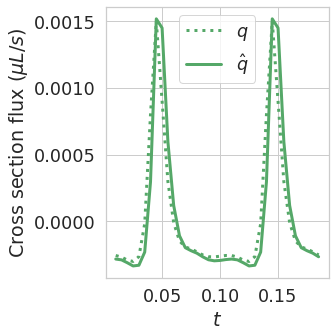

In [183]:
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=1.6, rc={"lines.linewidth": 3.0})

dt = params["dt"]

fig, ax = plt.subplots(figsize=(4, 5))

times = np.asarray(range(0, nsteps-2))*dt

plt.plot(times[2:], q_avg_bot[1:], 'g:', label='$q$')
plt.plot(times[2:], q1D_bot[0:-1], 'g-', label='$\hat{q}$')

ytick_vals = np.linspace(0, 0.001, 4)
ytick_labels = [f'{y:1.1e}' for y in ytick_vals]
ytick_labels = [label.replace('e-0', 'e-') for label in ytick_labels]
ytick_labels[2] = '0'

ax.set_xlabel('$t (s)$')
ax.set_ylabel('Cross section flux $(\\mu L/s)$')

#ax.set_yticks(ytick_vals)
#ax.set_yticklabels(ytick_labels)

ax.set_xlabel('$t$')

plt.legend()


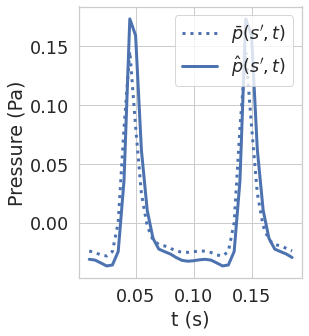

In [182]:
fig, ax = plt.subplots(figsize=(4, 5))

ax.set_xlabel('$t$')

ytick_vals = np.linspace(-0.05, 0.1, 4)
ytick_labels = [f'{y:1.2f}' for y in ytick_vals]
ytick_labels[1] = '0'

ax.plot(times[2:], p_avg_bot[1:], 'b:', label='$\\bar{p}(s\', t)$')
ax.plot(times[2:], p1D_bot[0:-1], 'b', label='$\hat{p}(s\',t)$')
ax.legend()

ax.set_ylabel('Pressure (Pa)')
ax.set_xlabel('t (s)')


In [133]:
# Compute radius over time
dt = 0.005
times = np.asarray(range(0, nsteps-1))*dt

DeltaRs = [project(DeltaR_a(t), p1D.function_space()) for t in times]


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FF

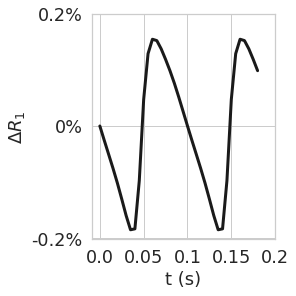

In [145]:
# Plot the radius over time
fig_q, axs_q = plt.subplots(1, 1, constrained_layout = True, figsize=(4,4))

# Plot Delta R_1 as a function of time

x0 = p1D.function_space().mesh().coordinates()[0,:]
DeltaRs_x0 = [DeltaR(x0)*100 for DeltaR in DeltaRs]
axs_q.plot( times, DeltaRs_x0, 'k')

# Specify y ticks
yticks = [-0.2, 0, 0.2]
ytick_labels = [f'{y}%' for y in yticks  ]

axs_q.set_yticks(yticks)
axs_q.set_yticklabels(ytick_labels)


# Specify x ticks
xticks = [0.0, 0.05, 0.1, 0.15, 0.2]
xtick_labels = [f'{x}' for x in xticks  ]
axs_q.set_xticks(xticks)
axs_q.set_xticklabels(xtick_labels)

# Set labels etc
axs_q.set_xlabel('t (s)', fontsize=18)
axs_q.set_ylabel('$\Delta R_1$', fontsize=18)


In [63]:
## Read change in radius over time ##
data_csv = plt.loadtxt('../src/mechanisms-behind-pvs-flow/2Daxi/mestre_spline_refined_data.dat')
x_data_refined, y_data_refined = data_csv

# Fitting dataset using scipy interpolate (piecewise linear)
import scipy.interpolate as sp_interpolate
fdata = sp_interpolate.interp1d(x_data_refined, y_data_refined)

cycle_duration = 0.1

R1, R2 = radius_a, radius_pv

def RelDeltaD(_t):
    # Percentage change in diameter at given time _t
    # Data is given for one cardiac cycle , x \in [0,1]
    val = fdata((_t/cycle_duration)%1)
    # The data are given in percents
    val = val*1e-2

    return val

def DeltaR_a(time): # R_a changes with time
    # Diameter change : the change of radius is radius <- radius + d0_expr
    L_PVS = R2 - R1 # PVS width
    # Diameter change is 0.5*RelDeltaD(time)*L_PVS
    return 0.5*RelDeltaD(time)*L_PVS/R1 # multiply by 0.5 to get radius change

-8.8267611642764e-08